In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Credit Status Dataset

## All features in a list:
### Categorical
* <span style="color:red">ID</span>
* <span style="color:red">Customer_ID</span>
* Month
* <span style="color:red">Name</span>
* <span style="color:red">SSN</span>
* Occupation
* Type of Loan
* Credit_mix
* Payment behaviour
* Credit history age
* Payment_of_min_amount

### Discrete
* Age
* Num_Bank_Accounts
* Interest Rate
* Num of Loan
* Delay_from_due_date
* Num_of_delayed_payment

### Continous
* Annual_Income
* Monthly_Inhand Salary
* Monthly_Balance

In [25]:
df = pd.read_csv('https://raw.githubusercontent.com/mau-JS/OracleML/main/credit-status-dataset.csv')
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22 Years and 9 Months,No,Low_spent_Small_value_payments,186.2667021
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22 Years and 10 Months,No,High_spent_Medium_value_payments,361.4440039
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23 Years and 0 Months,No,High_spent_Medium_value_payments,343.8268732
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,6,1,Credit-Builder Loan,3,1,Good,27 Years and 3 Months,No,High_spent_Large_value_payments,485.2984337


In [26]:
df = df.drop(['ID','Customer_ID','Name','SSN'],axis=1)
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance
0,September,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22 Years and 9 Months,No,Low_spent_Small_value_payments,186.2667021
1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22 Years and 10 Months,No,High_spent_Medium_value_payments,361.4440039
2,November,24,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462
3,December,24_,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23 Years and 0 Months,No,High_spent_Medium_value_payments,343.8268732
4,September,28,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,Good,27 Years and 3 Months,No,High_spent_Large_value_payments,485.2984337


In [27]:
correlation_matrix = df.corr()

ValueError: could not convert string to float: 'September'

In [ ]:
# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))  # Tamaño del gráfico
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

NameError: name 'correlation_matrix' is not defined

<Figure size 1000x800 with 0 Axes>

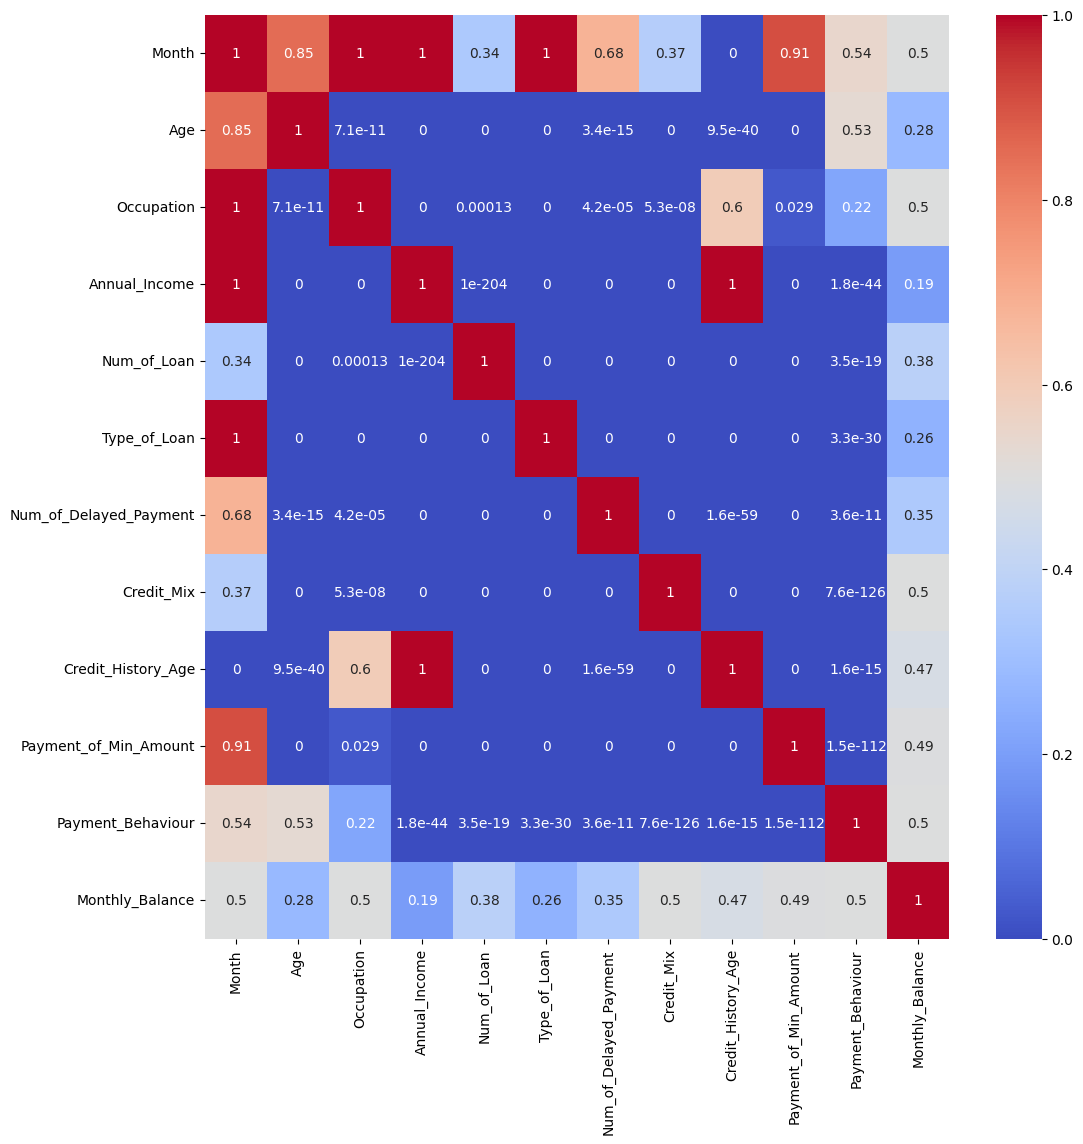

In [28]:
# List of categorical columns to exclude
exclude_cols = ['ID', 'Customer_ID', 'Name', 'SSN']

# Get a list of all categorical columns in df
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove the excluded columns from your list
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]

# Initialize a DataFrame to store the p-values
p_values = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Loop over each pair of categorical columns and perform Chi-Square test
for i in range(len(categorical_cols)):
    for j in range(i+1, len(categorical_cols)):
        contingency_table = pd.crosstab(df[categorical_cols[i]], df[categorical_cols[j]])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        # Store the p-value in the DataFrame
        p_values.loc[categorical_cols[i], categorical_cols[j]] = p

# Since the matrix is symmetric, copy the upper triangle values to the lower triangle
p_values = p_values.combine_first(p_values.T)

# Replace NaN values with 1 (since p-value for a variable with itself is 1)
p_values.fillna(1, inplace=True)
plt.figure(figsize=(12, 12))
# Plot the heatmap using seaborn
sns.heatmap(p_values.astype(float), cmap='coolwarm', annot=True)
plt.show()